<a href="https://colab.research.google.com/github/KADA-SEDODE/age-gender-prediction/blob/main/DL_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Réalisé par Cristian BEREGOI et Marvin KADA-SEDODE

# Détection de l'âge et du sexe : Prédire l'âge et le sexe à partir d'images de visages.  UTKFace Dataset

# le dataset UTKFace, qui est un jeu de données d’images de visages annotés avec l'âge, le sexe et l'ethnicité.

# Nombre total d'images chargées : 33488





In [ ]:
!pip install opencv-python

In [ ]:
#  Standard libraries
import os
import random
import cv2 # Import the cv2 module

#  Data manipulation & processing
import numpy as np
import pandas as pd
from PIL import Image

#  Visualisation
import matplotlib.pyplot as plt

import seaborn as sns

#  Progress bar
from tqdm import tqdm

#  PyTorch & TorchVision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import models, transforms

#  Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision.models import inception_v3, Inception_V3_Weights


In [ ]:
#Cela me permet de me connceter au compte google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PARTIE 1

# CHARGEMENT DES DONNEES

In [ ]:
import zipfile

# Définir les chemins
zip_path = "/content/drive/MyDrive/archive (1).zip"
extract_path = "/content/UTKFace"  # Chemin d'extraction

# Décompresser le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")


Extraction terminée !


In [ ]:
# Lister les 3 premiers fichiers extraits
files = os.listdir(extract_path)
print(f"Nombre total de repertoires: {len(files)}") #dans notre extract_path on aura un dossier avec des sous dossier à l'intérieure
print("Exemple de fichiers :", files[:3])
print()

Nombre total de repertoires: 3
Exemple de fichiers : ['crop_part1', 'UTKFace', 'utkface_aligned_cropped']



In [ ]:
# Chemin où le dataset a été extrait
extract_path = "/content/UTKFace"

# Vérifier les dossiers à l'intérieur
folders = os.listdir(extract_path)# ca nous liste les dossiers à l'interieure de extract_path
print("Dossiers trouvés :", folders)

# Vérifier le contenu des sous-dossiers
for folder in folders:
    folder_path = os.path.join(extract_path, folder)
    if os.path.isdir(folder_path):# nous dis si c'est un dossier
        print(f"\n➡ Contenu du dossier {folder}:")
        print(os.listdir(folder_path)[:10])  # Afficher les 10 premiers fichiers


Dossiers trouvés : ['crop_part1', 'UTKFace', 'utkface_aligned_cropped']

➡ Contenu du dossier crop_part1:
['76_1_0_20170110182047993.jpg.chip.jpg', '26_1_2_20170109002657161.jpg.chip.jpg', '75_0_2_20170110131323894.jpg.chip.jpg', '13_0_0_20170110224625011.jpg.chip.jpg', '39_0_4_20170104200746817.jpg.chip.jpg', '2_0_4_20161221202356481.jpg.chip.jpg', '52_0_4_20170104184746311.jpg.chip.jpg', '14_1_2_20170104012048369.jpg.chip.jpg', '85_1_0_20170110183746742.jpg.chip.jpg', '22_1_2_20170104020216916.jpg.chip.jpg']

➡ Contenu du dossier UTKFace:
['61_0_0_20170117174613406.jpg.chip.jpg', '32_1_1_20170113000615118.jpg.chip.jpg', '76_1_0_20170110182047993.jpg.chip.jpg', '26_1_2_20170109002657161.jpg.chip.jpg', '26_1_3_20170119193141890.jpg.chip.jpg', '27_1_2_20170116163003893.jpg.chip.jpg', '75_0_2_20170110131323894.jpg.chip.jpg', '32_1_0_20170117134803913.jpg.chip.jpg', '13_0_0_20170110224625011.jpg.chip.jpg', '49_1_1_20170113012017156.jpg.chip.jpg']

➡ Contenu du dossier utkface_aligned_crop

In [ ]:
image_folders = ["/content/UTKFace/crop_part1", "/content/UTKFace/UTKFace"] #on a les dossier des images

In [ ]:
# Fonction pour extraire âge et sexe depuis le nom de fichier
def extract_labels(filename):
    """Extrait l'âge et le sexe à partir du nom du fichier."""
    try:
        age, gender, _ = filename.split("_")[:3]
        return int(age), int(gender)
    except:
        return None, None

# Charger les images et labels
data = []
for folder in image_folders:
    for filename in tqdm(os.listdir(folder)): # Parcourt chaque fichier dans le dossier
        age, gender = extract_labels(filename) #  Extrait l'âge et le sexe du fichier.
        if age is not None:  #  Vérifie que l’extraction a réussi.
            img_path = os.path.join(folder, filename) # Construit le chemin complet de l’image.
            data.append((img_path, age, gender)) #  Ajoute l’image et ses labels à la liste.

# Convertir en numpy array
data = np.array(data, dtype=object)
print(f"Nombre total d'images chargées : {len(data)}")


100%|██████████| 23708/23708 [00:00<00:00, 297633.80it/s]

Nombre total d'images chargées : 33488


#  Visualiser la distribution des âges et sexes

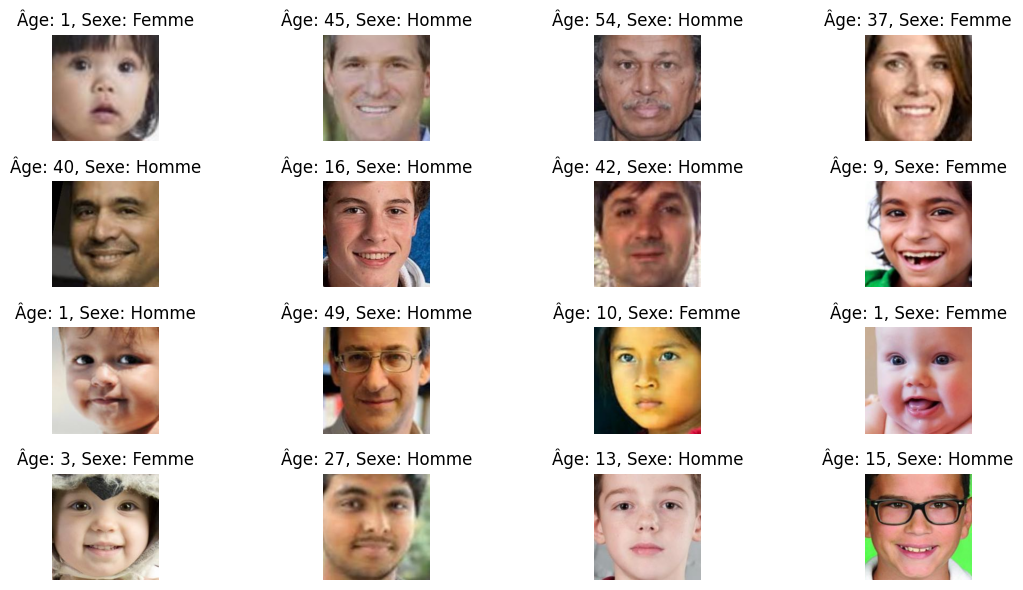

In [ ]:
def plot_images(data, num_images=16):
    """Affiche des images avec âge et sexe."""
    fig, axes = plt.subplots(4, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_images):
        img_path, age, gender = data[i] # # Récupère le chemin de l’image et les labels
        img = cv2.imread(img_path)  # charge l’image en utilisant OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convertit l’image en RGB pour qu’elle s’affiche correctement avec matplotlib.
        axes[i].imshow(img) #  affiche l’image dans le sous-graphique correspondant
        axes[i].set_title(f"Âge: {age}, Sexe: {'Homme' if gender == 0 else 'Femme'}") # ajoute un titre avec âge et sexe.
        axes[i].axis("off") # supprime les axes pour une meilleure visibilité.

    plt.tight_layout()
    plt.show()

# Afficher les images
plot_images(data)



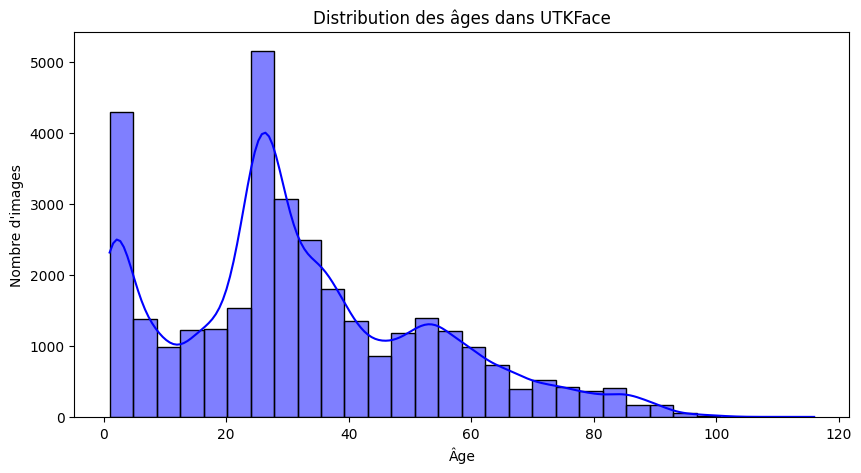

<ipython-input-12-2ea13bbe5ca8>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=genders, palette="coolwarm")


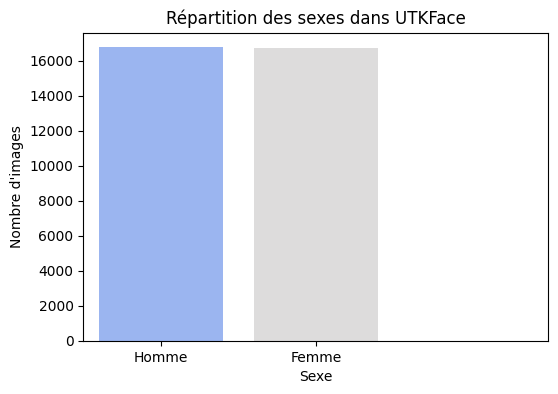

In [ ]:
# Extraire les âges et sexes
ages = [int(age) for _, age, _ in data]
genders = [int(gender) for _, _, gender in data]

# Distribution des âges
plt.figure(figsize=(10, 5))
sns.histplot(ages, bins=30, kde=True, color="blue")
plt.xlabel("Âge")
plt.ylabel("Nombre d'images")
plt.title("Distribution des âges dans UTKFace")
plt.show()

# Distribution des sexes
plt.figure(figsize=(6, 4))
sns.countplot(x=genders, palette="coolwarm")
plt.xticks(ticks=[0, 1], labels=["Homme", "Femme"])
plt.xlabel("Sexe")
plt.ylabel("Nombre d'images")
plt.title("Répartition des sexes dans UTKFace")
plt.show()


# PREPARATION DES DONNEES

In [ ]:
df_original = pd.DataFrame(data, columns=["image_path", "age", "gender"])
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33488 entries, 0 to 33487
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  33488 non-null  object
 1   age         33488 non-null  object
 2   gender      33488 non-null  object
dtypes: object(3)
memory usage: 785.0+ KB


In [ ]:
df_original.head()

,image_path,age,gender
0,/content/UTKFace/crop_part1/1_1_2_201612191935...,1,1
1,/content/UTKFace/crop_part1/45_0_0_20170104202...,45,0
2,/content/UTKFace/crop_part1/54_0_3_20170104220...,54,0
3,/content/UTKFace/crop_part1/37_1_0_20170105170...,37,1
4,/content/UTKFace/crop_part1/40_0_4_20170104204...,40,0


In [ ]:
nb_doublons=df_original.duplicated().sum()

In [ ]:
int(nb_doublons)

0

In [ ]:
unique_genders = df_original["gender"].nunique()
print("Nombre de valeurs uniques dans la colonne gender :", unique_genders)

Nombre de valeurs uniques dans la colonne gender : 3


In [ ]:
unique_values = df_original["gender"].unique()
print("Valeurs uniques dans la colonne gender :", unique_values)


Valeurs uniques dans la colonne gender : [1 0 3]


In [ ]:
# Supprimer les lignes où la colonne "gender" contient la valeur 3
df = df_original[df_original["gender"] != 3]

In [ ]:
df.shape
df["age"] = df["age"].astype(int)
df["gender"] = df["gender"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33487 entries, 0 to 33487
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  33487 non-null  object
 1   age         33487 non-null  int64 
 2   gender      33487 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


<ipython-input-15-b36f1723c1b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age"] = df["age"].astype(int)
<ipython-input-15-b36f1723c1b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gender"] = df["gender"].astype(int)


In [ ]:
unique_genders = df["gender"].nunique()
print("Nombre de valeurs uniques dans la colonne gender :", unique_genders)

Nombre de valeurs uniques dans la colonne gender : 2


##  Analyse des dimensions des images



In [ ]:
image_shapes = []
for img_path in df["image_path"].sample(30000):  # Tester sur 30000 images aléatoires
    img = cv2.imread(img_path)
    if img is not None:
        image_shapes.append(img.shape[:2])  # Hauteur, Largeur

# Convertir en DataFrame et voir les tailles les plus fréquentes
shape_df = pd.DataFrame(image_shapes, columns=["Height", "Width"])
print(shape_df.value_counts().head(10))  # Voir les 10 tailles d'image les plus fréquentes
print("Les images sont toutes de taille 200x200 →On va redimensioner en fonction du modèle choisi")


Height  Width
200     200      30000
Name: count, dtype: int64
Les images sont toutes de taille 200x200 →On va redimensioner en fonction du modèle choisi


## Création de tranches d’âges (binned classes)

<ipython-input-23-773a7c3fb274>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_group"] = pd.cut(df["age"], bins=np.arange(0, 101, 10))
<ipython-input-23-773a7c3fb274>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_distribution.index.astype(str), y=age_distribution.values, palette="Blues")


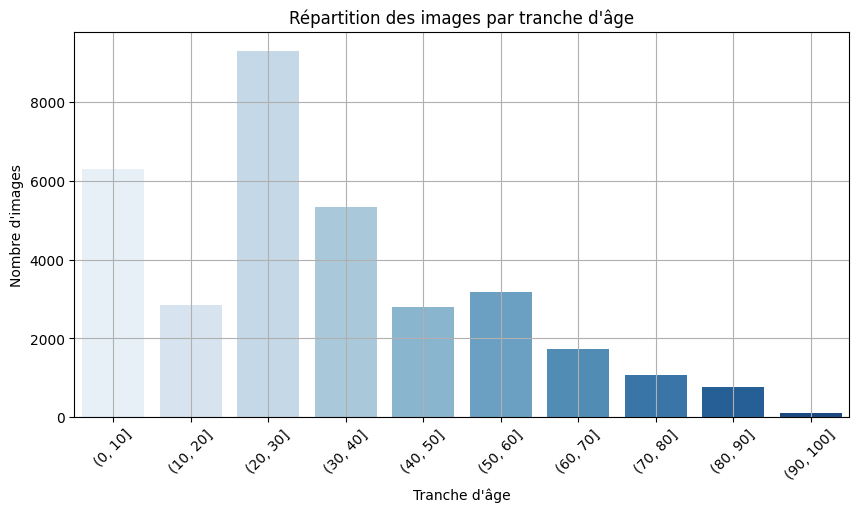

In [ ]:
# les âges par tranche de 10 ans
df["age_group"] = pd.cut(df["age"], bins=np.arange(0, 101, 10))

#  le nombre d'images par tranche d'âge
age_distribution = df["age_group"].value_counts().sort_index()

# Afficher les résultats
plt.figure(figsize=(10, 5))
sns.barplot(x=age_distribution.index.astype(str), y=age_distribution.values, palette="Blues")
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par tranche d'âge")
plt.xticks(rotation=45)
plt.grid()
plt.show()


## Répartition du sexe par tranche d'âge

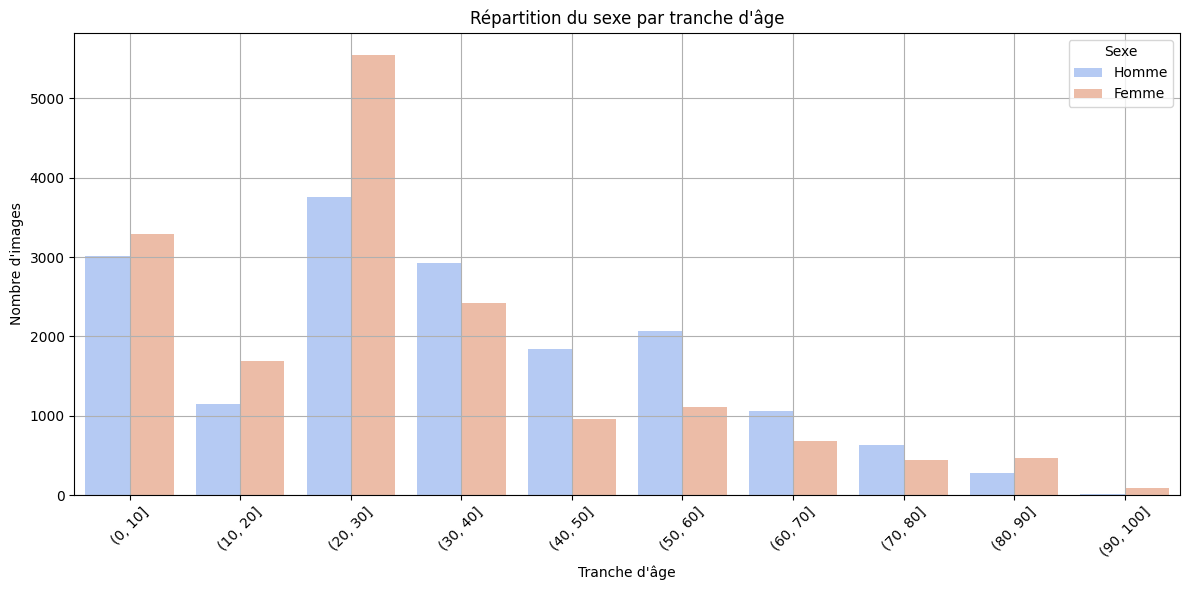

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="age_group", hue="gender", palette="coolwarm")
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre d'images")
plt.title("Répartition du sexe par tranche d'âge")
plt.xticks(rotation=45)
plt.legend(title="Sexe", labels=["Homme", "Femme"])
plt.tight_layout()
plt.grid()
plt.show()


## Heatmap âge × sexe (valeurs absolues ou normalisées)

<ipython-input-25-9bc3ce46c1d3>:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(heat_df, index="age_bin", columns="gender", values="image_path", aggfunc="count").fillna(0)


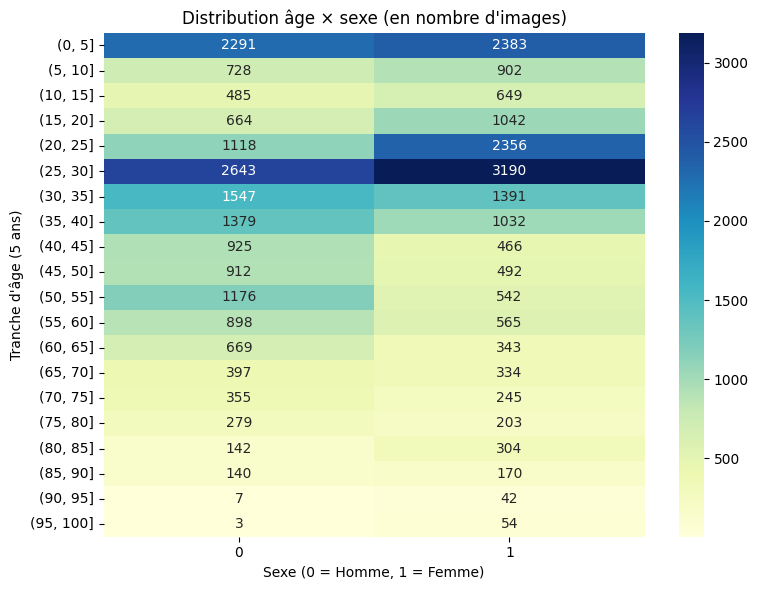

In [ ]:
heat_df = df.copy()
heat_df["age_bin"] = pd.cut(heat_df["age"], bins=np.arange(0, 101, 5))

pivot = pd.pivot_table(heat_df, index="age_bin", columns="gender", values="image_path", aggfunc="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Distribution âge × sexe (en nombre d'images)")
plt.xlabel("Sexe (0 = Homme, 1 = Femme)")
plt.ylabel("Tranche d'âge (5 ans)")
plt.tight_layout()
plt.show()


#  DECOUPAGE DU DATASET EN ENSEMBLE D'APPRENTISSAGE , VALIDATION , ET TEST .

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1997)

# Validation 10% du total depuis train

df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=1997)

# Affichage des tailles
print(f"Train : {len(df_train)} images")
print(f"Validation : {len(df_val)} images")
print(f"Test : {len(df_test)} images")

Train : 24110 images
Validation : 2679 images
Test : 6698 images


# Prétraitement et Data Augmentation

In [ ]:
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)


Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [ ]:
# Transformations pour TRAIN (avec Data Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # Redimensionne les images en 224x224 pixels (format standard)
    transforms.RandomHorizontalFlip(p=0.5), # Flip horizontal aléatoire avec 50% de probabilité (pour augmenter les données)
    transforms.RandomRotation(20),  # Rotation aléatoire jusqu'à 20 degrés (augmentation des données)
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),  # Recadrage aléatoire pour zoomer légèrement sur l'image, augmente diversité
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Modifie aléatoirement luminosité et contraste, améliore robustesse
    transforms.ToTensor(),  # Conversion de l'image PIL en Tensor PyTorch (format utilisable par PyTorch)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalisation des pixels (valeurs entre -1 et 1)
])

# Définition des transformations pour validation et test (PAS de Data Augmentation, seulement prétraitement basique)
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),  # Correction ici : Il y avait une erreur (224,2), on redimensionne en (224,224) pixels
    transforms.ToTensor(), # Conversion en tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Même normalisation que pour train, obligatoire pour cohérence
])

# CONSTRUCTION DES DATASET PERSONNALISES ET DES DATALOADER

Charge les données en mini-batchs → Optimise l’entraînement sur GPU.

- Permet le mélange aléatoire (shuffle=True) → Évite les biais d’apprentissage.
- Gère les images volumineuses → Charge les données en mémoire par petits morceaux, au lieu de tout charger d’un coup.
- Facilite le parallélisme (num_workers) → Accélère le chargement des données.

In [ ]:
# Classe personnalisée pour charger efficacement les images et labels
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

      # Récupération du chemin d'image, âge et sexe correspondant à l'index demandé
        img_path, age, gender = self.df.iloc[idx]["image_path"], self.df.iloc[idx]["age"], self.df.iloc[idx]["gender"]
        image = Image.open(img_path).convert("RGB")

       # Ouverture et conversion de l'image en format RGB
        if self.transform:
            image = self.transform(image)


        # labels = torch.tensor([age, gender], dtype=torch.float32)
        return image, {"age": torch.tensor(age, dtype=torch.float32),
               "gender": torch.tensor(gender, dtype=torch.float32)}


In [ ]:
# Création des datasets  avec transformations spécifiques
train_dataset = UTKFaceDataset(df_train, transform=train_transforms)
val_dataset = UTKFaceDataset(df_val, transform=test_transforms)
test_dataset = UTKFaceDataset(df_test, transform=test_transforms)

# Création des DataLoaders pour charger les images par batch durant l'entraînement
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Les DataLoaders sont prêts ")


Les DataLoaders sont prêts 


* Résumé : Préparation des données  

 À ce stade, les données ont été rigoureusement préparées :
 1. Nettoyage : suppression des valeurs aberrantes (e.g., gender = 3)
 2. Exploration : visualisation des distributions (âge, sexe, tranches d’âge)
 3. Découpage : split en Train (72%), Validation (8%), Test (20%)
 4. Prétraitement :
    - Normalisation des images (pixels entre -1 et 1)
    - Redimensionnement uniforme à 224×224
    - Data Augmentation appliquée uniquement sur le train (flip, rotation, jitter)

 Les données sont donc prêtes à être injectées dans un modèle CNN.




 Choix des architectures :
 Nous avons décidé d’expérimenter avec deux modèles pré-entraînés :
 - RESNET18 : léger, rapide, efficace pour un premier benchmark
 - InceptionV3 : plus profond, adapté aux tâches complexes (multitâche, haute précision)

  Étape suivante : définition et adaptation des modèles à notre tâche de prédiction d’âge (régression)
     et de sexe (classification binaire).

# PARTIE 2

# RESNET18 :
- Dans  notre cas on garde les premières couches, mais on remplace la dernière couche (Fully Connected) pour l’adapter à notre tâche.

Mais on se pose la question de hyper-parametres pour notre modèle .

Donc on teste et compare les performances de deux optimiseurs, SGD et Adam, avec différents learning rates

# Refacto :  
Problème : Le modèle ResNet18 était créé une seule fois et réutilisé pour toutes les combinaisons (optimiseur, learning rate).

Cela causait un biais d'apprentissage, car chaque nouveau test bénéficiait des poids déjà modifiés par les tests précédents.

Résultat : les pertes moyennes comparées étaient faussées, et le meilleur couple semblait meilleur simplement car il passait en dernier.

La correction a consisté à créer un nouveau modèle vierge à chaque combinaison via une fonction create_model().

Cela garantit que chaque test est indépendant, reproductible, et scientifiquement valide.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

def create_model():
    """Crée un nouveau modèle ResNet18 adapté à la double tâche âge + sexe."""
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # 1 sortie âge (régression), 1 sortie sexe (classification)
    )
    return model

# Fonctions de perte
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()

# Paramètres
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = {}

for opt_name in ["SGD", "Adam"]:
    for lr in learning_rates:
        print(f"\n🔁 {opt_name} | Learning Rate: {lr}")

        # Créer un nouveau modèle à chaque combinaison
        model = create_model().to(device)

        # Optimiseur
        if opt_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)
        else:
            optimizer = optim.Adam(model.parameters(), lr=lr)

        # Entraînement (1 époque pour test de perf)
        model.train()
        total_loss = 0.0

        for images, ages, genders in tqdm(train_loader):
            images, ages, genders = images.to(device), ages.to(device), genders.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Séparation des sorties
            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            # Pertes
            loss_age = criterion_age(predicted_age, ages)
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.5 * loss_age + loss_gender

            # Backprop
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        results[f"{opt_name}_lr_{lr}"] = avg_loss
        print(f"📉 Moyenne des pertes : {avg_loss:.4f}")

# Résumé des performances
print("\n📊 Résultats des configurations :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



🔁 SGD | Learning Rate: 0.001


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]
100%|██████████| 754/754 [03:14<00:00,  3.88it/s]


📉 Moyenne des pertes : 97.8058

🔁 SGD | Learning Rate: 0.0001


100%|██████████| 754/754 [03:16<00:00,  3.85it/s]


📉 Moyenne des pertes : 90.1394

🔁 SGD | Learning Rate: 1e-05


100%|██████████| 754/754 [03:12<00:00,  3.91it/s]


📉 Moyenne des pertes : 270.4876

🔁 SGD | Learning Rate: 1e-06


100%|██████████| 754/754 [03:14<00:00,  3.88it/s]


📉 Moyenne des pertes : 726.3594

🔁 Adam | Learning Rate: 0.001


100%|██████████| 754/754 [03:21<00:00,  3.75it/s]


📉 Moyenne des pertes : 87.2769

🔁 Adam | Learning Rate: 0.0001


100%|██████████| 754/754 [03:19<00:00,  3.77it/s]


📉 Moyenne des pertes : 106.0010

🔁 Adam | Learning Rate: 1e-05


100%|██████████| 754/754 [03:15<00:00,  3.87it/s]


📉 Moyenne des pertes : 478.3448

🔁 Adam | Learning Rate: 1e-06


100%|██████████| 754/754 [03:25<00:00,  3.68it/s]

📉 Moyenne des pertes : 719.9356

📊 Résultats des configurations :
SGD_lr_0.001: 97.8058
SGD_lr_0.0001: 90.1394
SGD_lr_1e-05: 270.4876
SGD_lr_1e-06: 726.3594
Adam_lr_0.001: 87.2769
Adam_lr_0.0001: 106.0010
Adam_lr_1e-05: 478.3448
Adam_lr_1e-06: 719.9356


- Pour l'optimiseur SGD le meilleure learning rate est de 1e-4.
- Pour l'optimiseur ADAM le meilleure learning rate de 1e-3.

#Je regarde le momentum a 0.1 pour SGD pour Resnet18

Momentum :  Méthode souvent utilisée avec l'optimizer SGD  pour aider le modèle à converger plus rapidement et de façon plus stable pendant l’entraînement.

Attention : néccessite beacoup de reglage manuel

In [ ]:
def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)
    )
    return model

momentum = 0.1
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
results = {}

for lr in learning_rates:
    print(f"\n Testing SGD | LR={lr}, Momentum={momentum}")

    #  Nouveau modèle vierge à chaque test
    model = create_model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    model.train()
    total_loss = 0.0

    for images, ages, genders in tqdm(train_loader):
        images, ages, genders = images.to(device), ages.to(device), genders.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages)
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    results[f"SGD_lr_{lr}_momentum_{momentum}"] = avg_loss
    print(f" Moyenne des pertes : {avg_loss:.4f}")

# Résumé
print("\n Résultats finaux :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



 Testing SGD | LR=0.001, Momentum=0.1


100%|██████████| 754/754 [03:11<00:00,  3.93it/s]


 Moyenne des pertes : 101.4330

 Testing SGD | LR=0.0001, Momentum=0.1


100%|██████████| 754/754 [03:10<00:00,  3.97it/s]


 Moyenne des pertes : 90.3730

 Testing SGD | LR=1e-05, Momentum=0.1


100%|██████████| 754/754 [03:11<00:00,  3.95it/s]


 Moyenne des pertes : 267.3931

 Testing SGD | LR=1e-06, Momentum=0.1


100%|██████████| 754/754 [03:12<00:00,  3.93it/s]

 Moyenne des pertes : 738.9205

 Résultats finaux :
SGD_lr_0.001_momentum_0.1: 101.4330
SGD_lr_0.0001_momentum_0.1: 90.3730
SGD_lr_1e-05_momentum_0.1: 267.3931
SGD_lr_1e-06_momentum_0.1: 738.9205


#On test SGD avec learning rate de 0.9

In [ ]:
def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # 2 sorties : âge et sexe
    )
    return model

# === Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]
results = {}

# === Boucle d'expérimentation
for lr in learning_rates:
    print(f"\n Testing SGD with a momentum of 0.9 | LR={lr}")

    model = create_model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum =0.9)
    model.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages)
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    results[f"SGD_lr_{lr}_momentum{0.9}"] = avg_loss
    print(f" Moyenne des pertes : {avg_loss:.4f}")

# Résumé
print("\n Résultats des tests SGD :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



 Testing SGD with a momentum of 0.9 | LR=0.001


100%|██████████| 754/754 [03:12<00:00,  3.92it/s]


 Moyenne des pertes : 263.1720

 Testing SGD with a momentum of 0.9 | LR=0.0001


100%|██████████| 754/754 [03:12<00:00,  3.92it/s]


 Moyenne des pertes : 85.9625

 Testing SGD with a momentum of 0.9 | LR=1e-05


100%|██████████| 754/754 [03:10<00:00,  3.95it/s]


 Moyenne des pertes : 100.3248

 Testing SGD with a momentum of 0.9 | LR=1e-06


100%|██████████| 754/754 [03:09<00:00,  3.98it/s]

 Moyenne des pertes : 322.3187

 Résultats des tests Adam :
SGD_lr_0.001_momentum0.9: 263.1720
SGD_lr_0.0001_momentum0.9: 85.9625
SGD_lr_1e-05_momentum0.9: 100.3248
SGD_lr_1e-06_momentum0.9: 322.3187


* Comparaison des pertes moyennes par méthode (1 epoch)

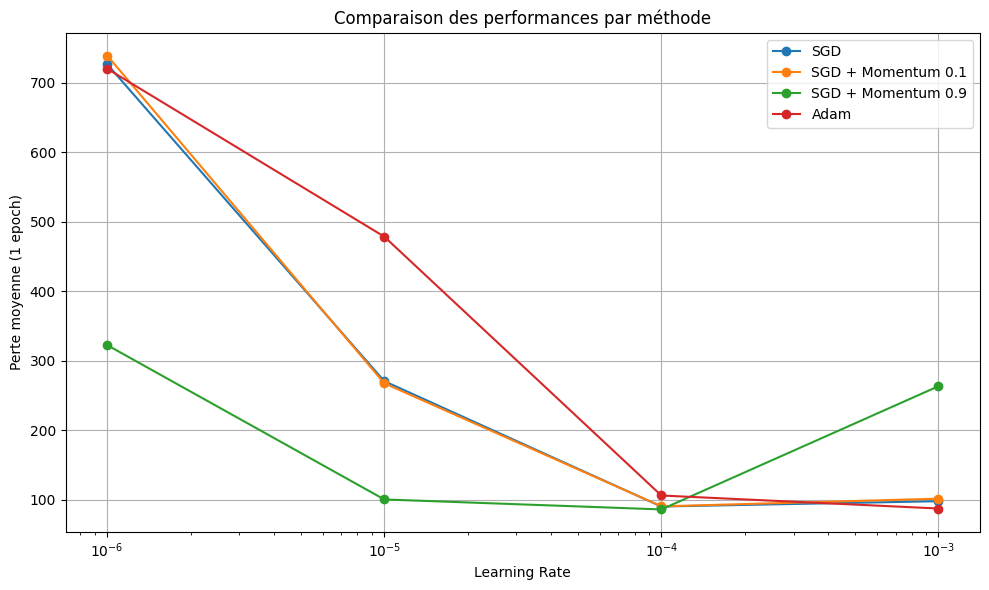

In [ ]:
# Courbes des pertes pour chaque méthode
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]

# Données récupérées depuis tes logs
sgd_losses =     [97.8058, 90.1394, 270.4876, 726.3594]
sgd_mom_1_losses = [101.4330, 90.3730, 267.3931, 738.9205]
sgd_mom_9_losses =[263.17, 85.96, 100.32, 322.3187]
adam_losses =    [87.2769, 106.0010, 478.3448, 719.9356]

# Tracer le lineplot
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, sgd_losses, label="SGD", marker='o')
plt.plot(learning_rates, sgd_mom_1_losses, label="SGD + Momentum 0.1", marker='o')
plt.plot(learning_rates, sgd_mom_9_losses, label="SGD + Momentum 0.9", marker='o')
plt.plot(learning_rates, adam_losses, label="Adam", marker='o')

# Log scale pour x car les LR varient beaucoup
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Perte moyenne (1 epoch)")
plt.title("Comparaison des performances par méthode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Commentaire : Le modèle ResNet18 obtient sa meilleure performance avec Adam (lr=1e-3).
SGD + momentum n’a pas apporté d’amélioration significative dans ce cas, mais reste plus stable à bas learning rate. Cependant le SGD pour un momentum de 0.9, on peut remarquer qu'il a un comportement different, mais 1e-4 reste le meilleure learning rate.

# REFACTO


* Adam : conçu pour être auto-régulateur, pas de momentum

In [ ]:
def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # 2 sorties : âge et sexe
    )
    return model

# === Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
results = {}

# === Boucle d'expérimentation
for lr in learning_rates:
    print(f"\n Testing Adam | LR={lr}")

    model = create_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages)
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    results[f"Adam_lr_{lr}"] = avg_loss
    print(f" Moyenne des pertes : {avg_loss:.4f}")

# Résumé
print("\n Résultats des tests Adam :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



 Testing Adam | LR=0.001


100%|██████████| 754/754 [03:13<00:00,  3.89it/s]


 Moyenne des pertes : 86.5082

 Testing Adam | LR=0.002


100%|██████████| 754/754 [03:23<00:00,  3.71it/s]


 Moyenne des pertes : 108.6181

 Testing Adam | LR=0.003


100%|██████████| 754/754 [03:14<00:00,  3.87it/s]


 Moyenne des pertes : 151.4920

 Testing Adam | LR=0.004


100%|██████████| 754/754 [03:17<00:00,  3.82it/s]


 Moyenne des pertes : 137.2504

 Testing Adam | LR=0.005


100%|██████████| 754/754 [03:34<00:00,  3.51it/s]


 Moyenne des pertes : 187.0613

 Testing Adam | LR=0.006


100%|██████████| 754/754 [03:17<00:00,  3.81it/s]


 Moyenne des pertes : 166.3480

 Testing Adam | LR=0.007


100%|██████████| 754/754 [03:17<00:00,  3.81it/s]


 Moyenne des pertes : 237.6608

 Testing Adam | LR=0.008


100%|██████████| 754/754 [03:17<00:00,  3.82it/s]


 Moyenne des pertes : 199.7856

 Testing Adam | LR=0.009


100%|██████████| 754/754 [03:16<00:00,  3.84it/s]

 Moyenne des pertes : 164.6275

 Résultats des tests Adam :
Adam_lr_0.001: 86.5082
Adam_lr_0.002: 108.6181
Adam_lr_0.003: 151.4920
Adam_lr_0.004: 137.2504
Adam_lr_0.005: 187.0613
Adam_lr_0.006: 166.3480
Adam_lr_0.007: 237.6608
Adam_lr_0.008: 199.7856
Adam_lr_0.009: 164.6275


Pour ADAM, le meilleure learnig rate est 0.001

 Meilleure config Adam : lr=0.0006 avec 78.9 de perte moyenne

In [ ]:
# === Fonction de création du modèle ===
def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # Sorties : âge, sexe
    )
    return model

# === Paramètres ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
momentum = 0.9
learning_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()
results = {}

# === Boucle de test pour chaque learning rate ===
for lr in learning_rates:
    print(f"\nTesting SGD | LR={lr}, Momentum={momentum}")

    model = create_model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    model.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages)
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    results[f"SGD_lr_{lr}_momentum_{momentum}"] = avg_loss
    print(f"Moyenne des pertes : {avg_loss:.4f}")

# === Résumé des performances
print("\n🔎 Résultats finaux :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



Testing SGD | LR=0.0001, Momentum=0.9


100%|██████████| 754/754 [03:26<00:00,  3.65it/s]


Moyenne des pertes : 87.6942

Testing SGD | LR=0.0002, Momentum=0.9


100%|██████████| 754/754 [03:19<00:00,  3.77it/s]


Moyenne des pertes : 114.0808

Testing SGD | LR=0.0003, Momentum=0.9


100%|██████████| 754/754 [03:11<00:00,  3.93it/s]


Moyenne des pertes : 123.2061

Testing SGD | LR=0.0004, Momentum=0.9


100%|██████████| 754/754 [03:11<00:00,  3.93it/s]


Moyenne des pertes : 198.7964

Testing SGD | LR=0.0005, Momentum=0.9


100%|██████████| 754/754 [03:10<00:00,  3.95it/s]


Moyenne des pertes : 232.7703

Testing SGD | LR=0.0006, Momentum=0.9


100%|██████████| 754/754 [03:11<00:00,  3.93it/s]


Moyenne des pertes : 239.0551

Testing SGD | LR=0.0007, Momentum=0.9


100%|██████████| 754/754 [03:10<00:00,  3.96it/s]


Moyenne des pertes : 258.4304

Testing SGD | LR=0.0008, Momentum=0.9


100%|██████████| 754/754 [03:10<00:00,  3.95it/s]


Moyenne des pertes : 229.5251

Testing SGD | LR=0.0009, Momentum=0.9


100%|██████████| 754/754 [03:23<00:00,  3.71it/s]

Moyenne des pertes : 265.1835

🔎 Résultats finaux :
SGD_lr_0.0001_momentum_0.9: 87.6942
SGD_lr_0.0002_momentum_0.9: 114.0808
SGD_lr_0.0003_momentum_0.9: 123.2061
SGD_lr_0.0004_momentum_0.9: 198.7964
SGD_lr_0.0005_momentum_0.9: 232.7703
SGD_lr_0.0006_momentum_0.9: 239.0551
SGD_lr_0.0007_momentum_0.9: 258.4304
SGD_lr_0.0008_momentum_0.9: 229.5251
SGD_lr_0.0009_momentum_0.9: 265.1835


Meilleure config SGD : lr=0.0001 avec 87.69 de perte moyenne

# Note :
Jusqu'a présent on a comparé deux optimisateurs, Adam (avec ses paramètres par défaut) et SGD avec momentum=0.9, en testant plusieurs valeurs de learning rate sur un modèle ResNet18 fine-tuné pour prédire l'âge (régression) et le sexe (classification binaire).

Pour Adam avec un learnig rate de 1e-3, on a que la perte moyenne de 86.5, alors que SGD a une perte de 87.7. Donc pour le SGD pour obrenir ces resulats ont demandé beaacoup de reglage manuel.

#Dans cette partie on va se concentrer que sur l'InceptionV3

#Ici on modifie transform, notament le resize et la normalisation.
La normalisation est légerement differente et aussi le crop.

In [ ]:
import torchvision.transforms as transforms

# Transformations pour TRAIN (avec Data Augmentation)
train_transforms_1 = transforms.Compose([
    transforms.Resize((299,299)), # Redimensionne les images en 299x299 pixels (format standard)
    transforms.RandomHorizontalFlip(p=0.5), # Flip horizontal aléatoire avec 50% de probabilité (pour augmenter les données)
    transforms.RandomRotation(20),  # Rotation aléatoire jusqu'à 20 degrés (augmentation des données)
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),  # Recadrage aléatoire pour zoomer légèrement sur l'image, augmente diversité
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Modifie aléatoirement luminosité et contraste, améliore robustesse
    transforms.ToTensor(),  # Conversion de l'image PIL en Tensor PyTorch (format utilisable par PyTorch)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalisation des pixels (valeurs entre -1 et 1)
])

## Définition des transformations pour validation et test (PAS de Data Augmentation, seulement prétraitement basique)
test_transforms_1 = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(), # Conversion en tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Même normalisation que pour train, obligatoire pour cohérence
])

In [ ]:
train_dataset_1 = UTKFaceDataset(df_train, transform=train_transforms_1)
val_dataset_1 = UTKFaceDataset(df_val, transform=test_transforms_1)
test_dataset_1 = UTKFaceDataset(df_test, transform=test_transforms_1)

# Création des DataLoaders pour charger les images par batch durant l'entraînement
train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=32, shuffle=False)
test_loader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False)

print("Les DataLoaders sont prêts ")


Les DataLoaders sont prêts 


In [ ]:
len(train_dataset_1)

24110

# Echantillon de 20% de data train, puis comparaison des deux optimiseurs

# Refacto  :

In [ ]:
# === Sous-échantillonnage du dataset (20% des données d'entraînement) ===
subset_size = int(len(train_dataset_1) * 0.2)
subset_indices = random.sample(range(len(train_dataset_1)), subset_size)
train_subset = Subset(train_dataset_1, subset_indices)
# Création du DataLoader pour le sous-échantillon
subset_train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

# Fonction pour réinitialiser le modèle aux poids initiaux d'InceptionV3
from torchvision.models import inception_v3, Inception_V3_Weights

In [ ]:
print(f"Entraîment sur 20% de la data train ({len(subset_train_loader.dataset)} échantillons).")


def reset_model():
    inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
    num_features = inception.fc.in_features
    inception.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # 2 sorties : âge et sexe
    )
    return inception.to(device)

# Transfert sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Fonctions de perte ===
criterion_age = nn.MSELoss()  # Régression pour l'âge
criterion_gender = nn.BCEWithLogitsLoss()  # Classification pour le sexe

# === Valeurs d'apprentissage et optimisateurs ===
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]
results = {}

# === Boucle pour tester chaque combinaison ===
for opt_name in ["SGD", "Adam"]:
    print(f"Testing {opt_name} optimizer...")

    for lr in learning_rates:
        inception = reset_model()    # la fonction reset
        if opt_name == "SGD":
            optimizer = optim.SGD(inception.parameters(), lr=lr)
        else:
            optimizer = optim.Adam(inception.parameters(), lr=lr)

        print(f"Testing {opt_name} with learning rate {lr}...")

        inception.train()
        total_loss = 0.0

        for images, labels_dict in tqdm(subset_train_loader):
            images = images.to(device)
            ages = labels_dict["age"].to(device)
            genders = labels_dict["gender"].to(device)

            optimizer.zero_grad()
            outputs = inception(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Si Inception retourne (aux_logits, logits)

            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            loss_age = criterion_age(predicted_age, ages) / 100  # On divise par 100 car MSE très grande
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.5 * loss_age + loss_gender

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(subset_train_loader)
        results[f"{opt_name}_lr_{lr}"] = avg_loss
        print(f"Average Loss: {avg_loss}")


Entraîment sur 20% de la data train (4822 échantillons).
Testing SGD optimizer...
Testing SGD with learning rate 0.001...


100%|██████████| 151/151 [01:43<00:00,  1.46it/s]


Average Loss: 8.002230966327996
Testing SGD with learning rate 0.0001...


100%|██████████| 151/151 [01:43<00:00,  1.45it/s]


Average Loss: 8.247539008690032
Testing SGD with learning rate 1e-05...


100%|██████████| 151/151 [01:44<00:00,  1.45it/s]


Average Loss: 8.224739630490738
Testing SGD with learning rate 1e-06...


100%|██████████| 151/151 [01:44<00:00,  1.45it/s]


Average Loss: 8.332776044378218
Testing Adam optimizer...
Testing Adam with learning rate 0.001...


100%|██████████| 151/151 [01:44<00:00,  1.44it/s]


Average Loss: 1.9760578764195473
Testing Adam with learning rate 0.0001...


100%|██████████| 151/151 [01:44<00:00,  1.44it/s]


Average Loss: 3.4653355060823707
Testing Adam with learning rate 1e-05...


100%|██████████| 151/151 [01:44<00:00,  1.44it/s]


Average Loss: 7.8749219029155
Testing Adam with learning rate 1e-06...


100%|██████████| 151/151 [01:44<00:00,  1.44it/s]

Average Loss: 8.256263571859195


## SGD vs Adam - InceptionV3 (20% Training Set)

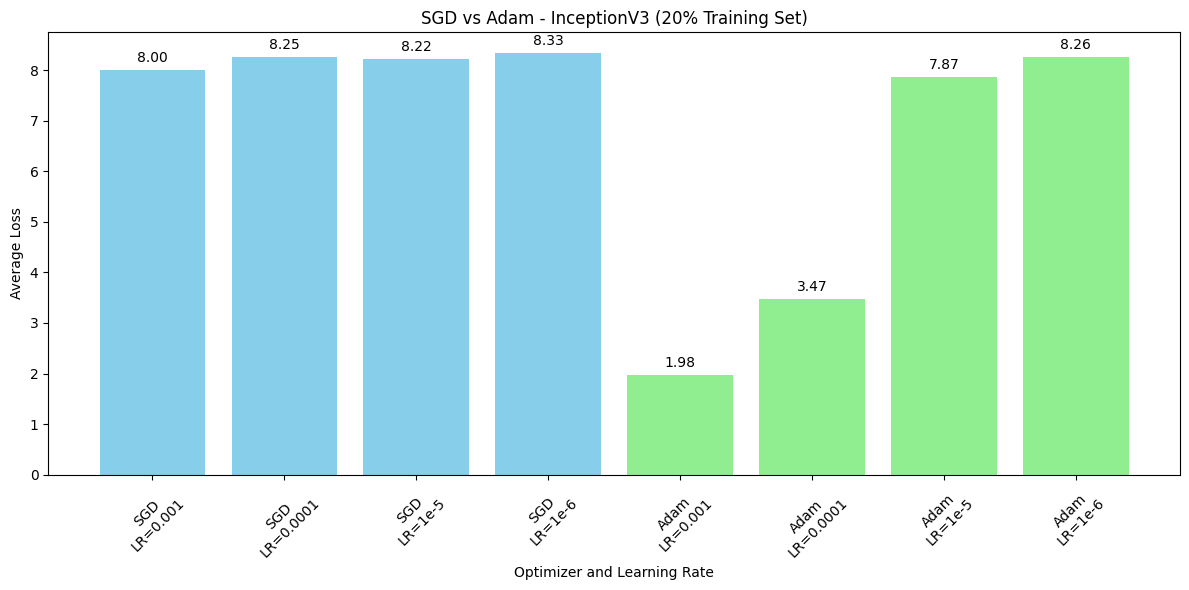

In [ ]:
# Données
optimizers = ['SGD', 'SGD', 'SGD', 'SGD', 'Adam', 'Adam', 'Adam', 'Adam']
learning_rates = ['0.001', '0.0001', '1e-5', '1e-6', '0.001', '0.0001', '1e-5', '1e-6']
losses = [8.00, 8.25, 8.22, 8.33, 1.98, 3.47, 7.87, 8.26]

# Couleurs pour les barres
colors = ['skyblue' if opt == 'SGD' else 'lightgreen' for opt in optimizers]

# Création du barplot
plt.figure(figsize=(12, 6))
bars = plt.bar([f'{opt}\nLR={lr}' for opt, lr in zip(optimizers, learning_rates)], losses, color=colors)

# Ajout des annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom')

# Paramètres du graphique
plt.title("SGD vs Adam - InceptionV3 (20% Training Set)")
plt.ylabel("Average Loss")
plt.xlabel("Optimizer and Learning Rate")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Ce qu’il faut retenir de cette comparaison
 Adam (LR = 0.001) donne la meilleure performance avec une loss ≈ 1.98, bien plus basse que n’importe quel autre essai.

SGD stagne entre 8.00 et 8.33, quel que soit le learning rate → il n'apprend presque rien dans ce setup.

Adam avec LR faible (1e-5 / 1e-6) ≈ les performances de SGD → sous-apprentissage (trop petit LR).

Adam est clairement plus adapté dans ce cas (InceptionV3 + multitâche âge/genre sur UTKFace), sans tuning complexe.



#Ici a éte definie la fonction reset, pour que le poids du modèle Inception soit reintialiser pour Adam.

#Ici je regarde SGD avec un momentum de 0.9

# Refacto :  

Ligne problématique dans le code original :

optimizers = {"SGD": [optim.SGD(inception.parameters(), lr=lr, momentum=0.9) for lr in learning_rates]}


In [ ]:
# Affichage de la taille du sous-échantillon
print(f"Entraînement sur 20% de la data train ({len(subset_train_loader.dataset)} échantillons).")

# Transfert sur GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonctions de perte
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()

# Learning rates à tester
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]

# Dictionnaire pour stocker les résultats
results = {}

# Optimiseur à tester : SGD avec momentum
opt_name = "SGD"
print(f"Testing {opt_name} optimizer...")

for lr in learning_rates:
    print(f"Testing {opt_name} with learning rate {lr}...")

    #  Réinitialisation complète du modèle pour CHAQUE learning rate
    inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
    num_features = inception.fc.in_features
    inception.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # Sorties : âge et sexe
    )
    inception = inception.to(device)

    optimizer = optim.SGD(inception.parameters(), lr=lr, momentum=0.9)

    # Entraînement
    inception.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(subset_train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = inception(images)

        # Si le modèle renvoie un tuple (cas d’InceptionV3), on prend la sortie principale
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages) / 100  # MSE très grande sinon
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(subset_train_loader)
    results[f"{opt_name}_lr_{lr}"] = avg_loss
    print(f"Average Loss: {avg_loss:.4f}")

Entraînement sur 20% de la data train (4822 échantillons).
Testing SGD optimizer...
Testing SGD with learning rate 0.001...


100%|██████████| 151/151 [01:47<00:00,  1.40it/s]


Average Loss: 4.0678
Testing SGD with learning rate 0.0001...


100%|██████████| 151/151 [01:55<00:00,  1.31it/s]


Average Loss: 8.1466
Testing SGD with learning rate 1e-05...


100%|██████████| 151/151 [01:45<00:00,  1.43it/s]


Average Loss: 8.2383
Testing SGD with learning rate 1e-06...


100%|██████████| 151/151 [01:41<00:00,  1.48it/s]

Average Loss: 8.2019


## SGD vs Adam - InceptionV3 (20% Training Set)

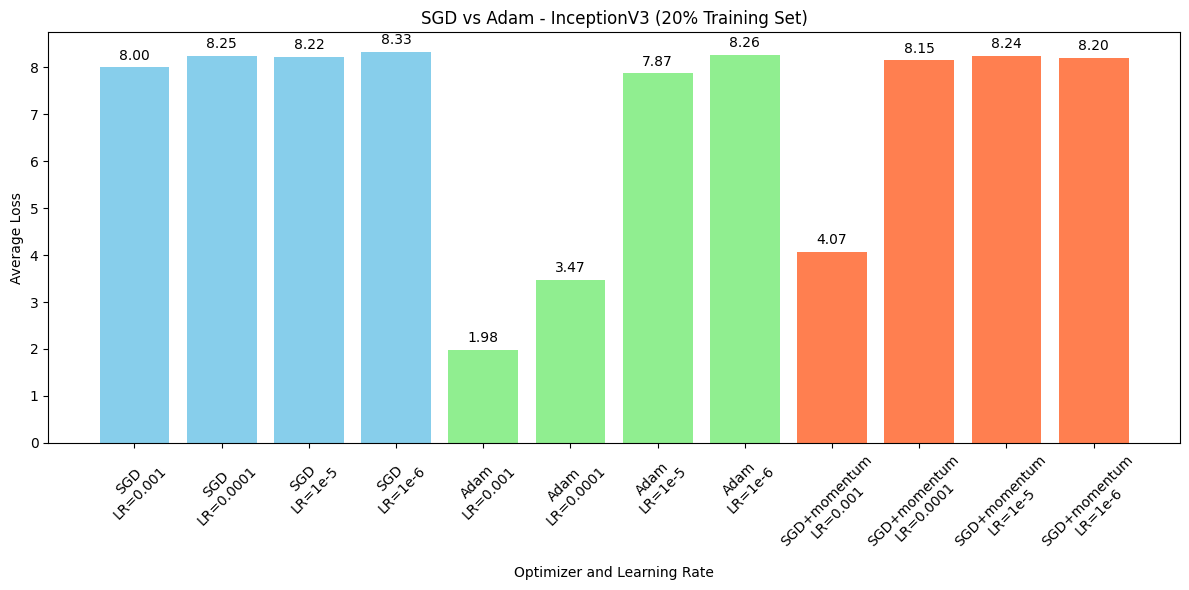

In [ ]:
# Données
optimizers = ['SGD', 'SGD', 'SGD', 'SGD', 'Adam', 'Adam', 'Adam', 'Adam', 'SGD+momentum', 'SGD+momentum', 'SGD+momentum', 'SGD+momentum']
learning_rates = ['0.001', '0.0001', '1e-5', '1e-6'] * 3
losses = [8.00, 8.25, 8.22, 8.33, 1.98, 3.47, 7.87, 8.26, 4.0678,8.1466,8.2383,8.2019]

# Couleurs pour les barres
colors = ['skyblue' if opt == 'SGD' else 'coral' if opt == 'SGD+momentum' else 'lightgreen' for opt in optimizers]

# Création du barplot
plt.figure(figsize=(12, 6))
bars = plt.bar([f'{opt}\nLR={lr}' for opt, lr in zip(optimizers, learning_rates)], losses, color=colors)

# Ajout des annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom')

# Paramètres du graphique
plt.title("SGD vs Adam - InceptionV3 (20% Training Set)")
plt.ylabel("Average Loss")
plt.xlabel("Optimizer and Learning Rate")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


* On voit clarement une amelioration de SGD avec momentum ------> Sans momentum, SGD échoue totalement ici

*  Adam est très performant à 1e-3, mais se dégrade fortement ensuite.

* On observe que SGD sans momentum est inefficace sur ce dataset avec InceptionV3.
* L'ajout de momentum (0.9) améliore nettement les performances à LR=1e-3, mais reste loin des résultats obtenus avec Adam.
* Adam à LR=1e-3 surpasse tous les autres réglages, confirmant sa robustesse et efficacité en mode "plug & play".
➤ Pour ce cas précis, Adam reste le meilleur choix, mais SGD+momentum pourrait être compétitif avec un meilleur tuning (scheduler, warmup, batch size...).



* ma note : 	Il faut toujours réinitialiser les poids du modèle pour tester équitablement chaque learning rate.

le meilleur learning rate est clairement 0.001, pas 0.0001.
Et plus tu diminues le learning rate, moins le modèle converge, ce qui est logique sans "poids chauds".

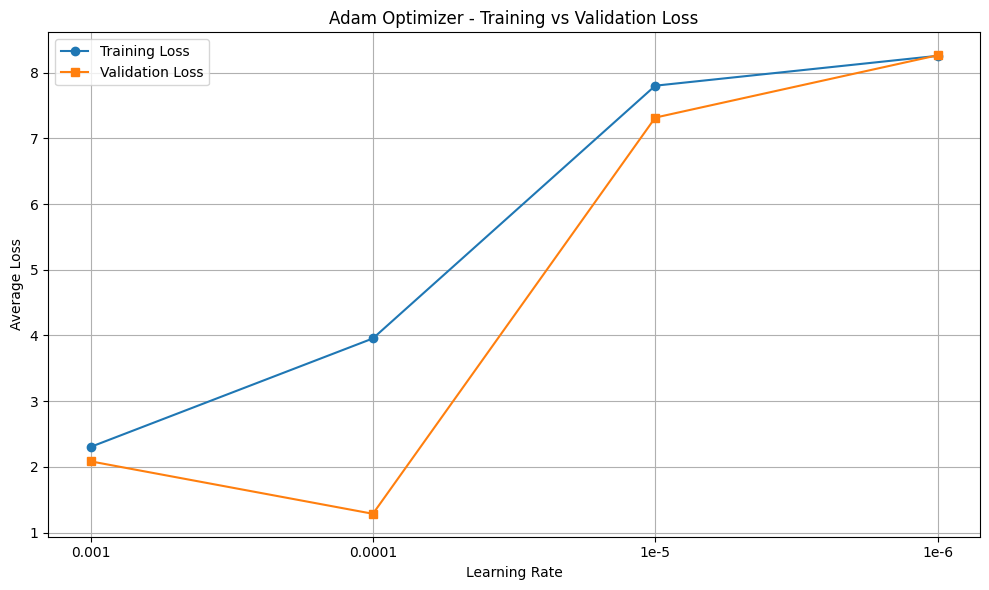

In [ ]:
# Données de pertes après correction
learning_rates = ["0.001", "0.0001", "1e-5", "1e-6"]
train_losses = [2.3040, 3.9552, 7.8005, 8.2550]
val_losses = [2.0855, 1.2872, 7.3151, 8.2635]

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_losses, marker='o', label='Training Loss')
plt.plot(learning_rates, val_losses, marker='s', label='Validation Loss')
plt.xlabel("Learning Rate")
plt.ylabel("Average Loss")
plt.title("Adam Optimizer - Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


------> Apres refacto
À 0.001, la perte d'entraînement (2.30) et de validation (2.08) sont plus proches, ce qui traduit un modèle plus stable et mieux régularisé.

Les valeurs très faibles (1e-05 et 1e-06) montrent une stagnation, ce qui est attendu car le learning rate est trop bas pour converger efficacement.

 Conclusion : Le meilleur compromis ici est 0.001, car il permet un bon entraînement sans sur-apprentissage, avec des pertes cohérentes sur le train et le val.
Il est donc erroné de conclure que 0.0001 est la meilleure option à partir de ces résultats."

# Pondération différente entre les deux pertes (0.7 * loss_age + loss_gender).

# Refacto

In [ ]:
#  Test affiné du learning rate pour l’optimiseur Adam (sur 20% des données)

print(f"Entraînement sur 20% de la data train ({len(subset_train_loader.dataset)} échantillons).")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonctions de perte
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()

# Liste des learning rates à tester
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
results = {}

# Boucle d’évaluation pour chaque learning rate
for lr in learning_rates:
    print(f"\n Testing Adam with learning rate {lr}...")

    # Réinitialisation du modèle à chaque fois
    inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
    num_features = inception.fc.in_features
    inception.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)
    )
    inception = inception.to(device)

    optimizer = optim.Adam(inception.parameters(), lr=lr)
    inception.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(subset_train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = inception(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages) / 100
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.7 * loss_age + loss_gender  #  pondération modifiée ici

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(subset_train_loader)
    results[f"Adam_lr_{lr}"] = avg_loss
    print(f"Average Loss: {avg_loss:.4f}")


Entraînement sur 20% de la data train (4822 échantillons).

 Testing Adam with learning rate 0.001...


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 161MB/s] 
100%|██████████| 151/151 [01:49<00:00,  1.37it/s]


Average Loss: 2.6382

 Testing Adam with learning rate 0.002...


100%|██████████| 151/151 [01:49<00:00,  1.38it/s]


Average Loss: 3.3287

 Testing Adam with learning rate 0.003...


100%|██████████| 151/151 [01:51<00:00,  1.35it/s]


Average Loss: 4.5495

 Testing Adam with learning rate 0.004...


100%|██████████| 151/151 [01:51<00:00,  1.35it/s]


Average Loss: 4.4055

 Testing Adam with learning rate 0.005...


100%|██████████| 151/151 [01:51<00:00,  1.35it/s]


Average Loss: 4.5434

 Testing Adam with learning rate 0.006...


100%|██████████| 151/151 [01:47<00:00,  1.40it/s]


Average Loss: 4.5128

 Testing Adam with learning rate 0.007...


100%|██████████| 151/151 [01:51<00:00,  1.36it/s]


Average Loss: 4.2658

 Testing Adam with learning rate 0.008...


100%|██████████| 151/151 [01:51<00:00,  1.35it/s]

Average Loss: 4.4532


 * Avant correction (pas de reset, poids biaisés)
   Observation faussement optimiste : les pertes sont bien plus basses car les poids étaient déjà partiellement entraînés.

 * Après correction (avec réinitialisation + weights=DEFAULT)

Évolution de la Loss Moyenne selon le Learning Rate (Adam, après correction)

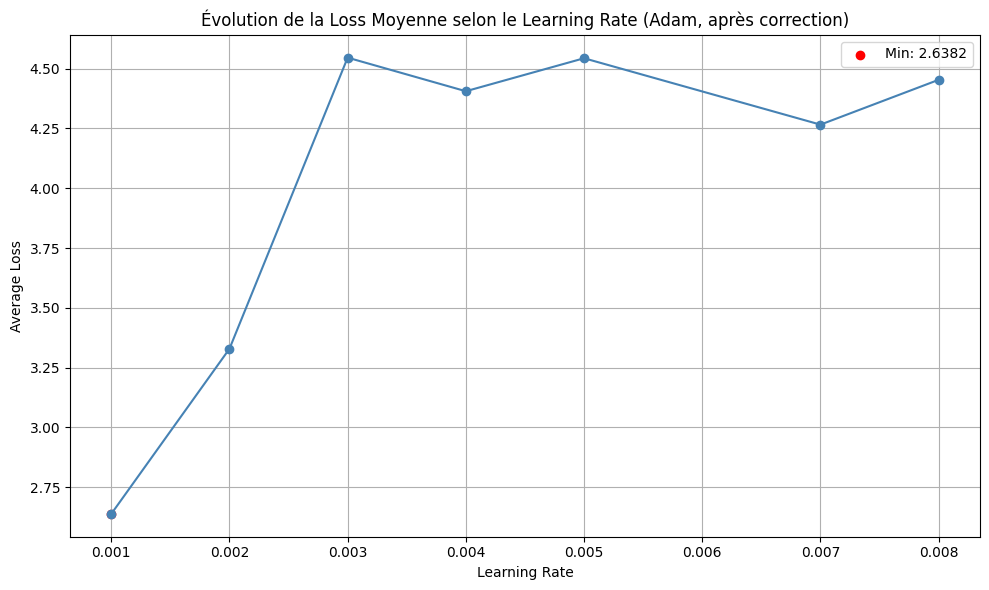

In [ ]:
import matplotlib.pyplot as plt

# Données initiales
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005, 0.000, 0.007, 0.008]
losses = [2.6382, 3.3287, 4.5459, 4.4055, 4.5434, 4.5128, 4.2658, 4.4532]

# Suppression de learning_rate = 0 si souhaité (facultatif)
# Si tu veux le garder, ignore cette section
lr_losses = [(lr, loss) for lr, loss in zip(learning_rates, losses) if lr > 0]

# Tri des données par learning rate
lr_losses.sort()
sorted_learning_rates, sorted_losses = zip(*lr_losses)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(sorted_learning_rates, sorted_losses, marker='o', linestyle='-', color='steelblue')
plt.title("Évolution de la Loss Moyenne selon le Learning Rate (Adam, après correction)")
plt.xlabel("Learning Rate")
plt.ylabel("Average Loss")
plt.grid(True)

# Mise en évidence du point minimum
min_index = sorted_losses.index(min(sorted_losses))
plt.scatter(sorted_learning_rates[min_index], sorted_losses[min_index], color='red', label=f"Min: {sorted_losses[min_index]:.4f}")
plt.legend()

plt.tight_layout()
plt.show()


# Conclusion:
Plus le learning rate augmente, plus la perte moyenne augmente egalement. Donc le meilleure learning rate est de 1e-3.

# Tester l’impact du taux de Dropout sur les performances du modèle InceptionV3
Le learning rate de 0.01 nous intéresse.

In [ ]:
def train_model(dropout_rate, learning_rate=0.001):  # <== ici le lr est 0.001
    print(f"Testing dropout={dropout_rate} with learning rate {learning_rate}...")

    # Charger InceptionV3 pré-entraîné
    inception = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)
    num_features = inception.fc.in_features

    # Remplacer la dernière couche Fully Connected avec le dropout variable
    inception.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(128, 2)
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception = inception.to(device)

    criterion_age = nn.MSELoss()
    criterion_gender = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(inception.parameters(), lr=learning_rate)

    inception.train()
    total_loss = 0.0

    for images, labels in tqdm(subset_train_loader):
        images = images.to(device)
        ages = labels["age"].to(device)
        genders = labels["gender"].to(device)

        optimizer.zero_grad()
        outputs = inception(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages) / 100
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.7 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(subset_train_loader)
    print(f"Average Loss with dropout={dropout_rate}: {avg_loss}")
    return inception, avg_loss


def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0.0
    criterion_age = nn.MSELoss()
    criterion_gender = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            ages = labels["age"].to(device)
            genders = labels["gender"].to(device)

            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            loss_age = criterion_age(predicted_age, ages) / 100
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.7 * loss_age + loss_gender

            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss


In [ ]:
dropouts = [0.3, 0.4]
results = {}

for d in dropouts:
    print(f"\n=== Training with dropout={d} ===")
    model, train_loss = train_model(d, learning_rate=0.001)
    val_loss = evaluate_model(model, val_loader_1)

    results[f"dropout_{d}"] = {
        "train_loss": train_loss,
        "val_loss": val_loss
    }

    print(f"Train Loss with dropout={d}: {train_loss:.4f}")
    print(f"Validation Loss with dropout={d}: {val_loss:.4f}")



=== Training with dropout=0.3 ===
Testing dropout=0.3 with learning rate 0.001...


100%|██████████| 151/151 [01:55<00:00,  1.31it/s]


Average Loss with dropout=0.3: 2.6299302949021195


100%|██████████| 84/84 [00:23<00:00,  3.59it/s]


Train Loss with dropout=0.3: 2.6299
Validation Loss with dropout=0.3: 1.6918

=== Training with dropout=0.4 ===
Testing dropout=0.4 with learning rate 0.001...


100%|██████████| 151/151 [01:47<00:00,  1.40it/s]


Average Loss with dropout=0.4: 2.9165631895823196


100%|██████████| 84/84 [00:22<00:00,  3.70it/s]

Train Loss with dropout=0.4: 2.9166
Validation Loss with dropout=0.4: 1.7486


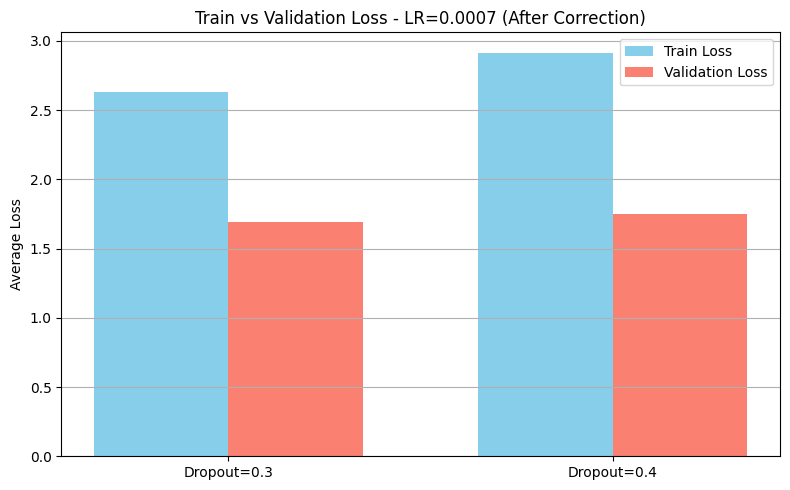

In [ ]:
# Données après correction
dropouts = [0.3, 0.4]
train_losses = [2.6299, 2.9166]
val_losses = [1.6918, 1.7486]

# Création du graphique comparatif
x = range(len(dropouts))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([i - bar_width / 2 for i in x], train_losses, width=bar_width, label='Train Loss', color='skyblue')
plt.bar([i + bar_width / 2 for i in x], val_losses, width=bar_width, label='Validation Loss', color='salmon')

plt.xticks(x, [f'Dropout={d}' for d in dropouts])
plt.ylabel("Average Loss")
plt.title("Train vs Validation Loss - LR=0.0007 (After Correction)")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()


Conclusion :
On remarque que les resulatats sont trés proche, mais on va rester sur led dropout de 0.3.

# Évaluation de la taille de la couche fully connected sur InceptionV3 avec Dropout et Adam



# Refacto

Entraînement : loss = 0.5 * loss_age + loss_gender

Validation : loss = 0.7 * loss_age + loss_gender
👉 Cela biaise un peu la comparaison entre train/val. Il vaudrait mieux garder les mêmes pondérations dans les deux cas, sauf raison précise et justifiée.

In [ ]:
def train_and_evaluate_fully_connected(num_neurons_list, learning_rate, dropout_value, subset_train_loader, val_loader, criterion_age, criterion_gender, device):
    results = {}  # Stockage des résultats pour chaque taille de couche FC

    for num_neurons in num_neurons_list:
        print(f"\nTesting Fully Connected Layer with {num_neurons} neurons...")

        # Charger un nouveau modèle InceptionV3 avec poids corrects
        inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)

        # Remplacer la dernière couche Fully Connected
        num_features = inception.fc.in_features
        inception.fc = nn.Sequential(
            nn.Linear(num_features, num_neurons),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(num_neurons, 2)  # 2 sorties : âge et sexe
        )
        inception = inception.to(device)

        # Optimiseur
        optimizer = optim.Adam(inception.parameters(), lr=learning_rate)

        # === Entraînement ===
        inception.train()
        total_train_loss = 0.0

        for images, labels_dict in tqdm(subset_train_loader):
            images = images.to(device)
            ages = labels_dict["age"].to(device)
            genders = labels_dict["gender"].to(device)

            optimizer.zero_grad()
            outputs = inception(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            loss_age = criterion_age(predicted_age, ages) / 100
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.7 * loss_age + loss_gender  # pondération uniforme pour cohérence

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(subset_train_loader)

        # === Validation ===
        inception.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for images, labels_dict in val_loader:
                images = images.to(device)
                ages = labels_dict["age"].to(device)
                genders = labels_dict["gender"].to(device)

                outputs = inception(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                predicted_age = outputs[:, 0]
                predicted_gender = outputs[:, 1]

                loss_age = criterion_age(predicted_age, ages) / 100
                loss_gender = criterion_gender(predicted_gender, genders)
                loss = 0.7 * loss_age + loss_gender  # même pondération

                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        results[f"{num_neurons}_neurons"] = {
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss
        }

        print(f"Average Training Loss for {num_neurons} neurons: {avg_train_loss:.4f}")
        print(f"Average Validation Loss for {num_neurons} neurons: {avg_val_loss:.4f}")

    return results


# === Hyperparamètres ===
num_neurons_list = [64, 128, 256]
learning_rate = 0.001  #  Meilleure valeur observée précédemment
dropout_value = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Fonctions de perte ===
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()

# === Appel de la fonction ===
results = train_and_evaluate_fully_connected(
    num_neurons_list=num_neurons_list,
    learning_rate=learning_rate,
    dropout_value=dropout_value,
    subset_train_loader=subset_train_loader,
    val_loader=val_loader_1,
    criterion_age=criterion_age,
    criterion_gender=criterion_gender,
    device=device
)

# === Affichage des résultats finaux ===
print("\nRésultats finaux :")
for neurons, losses in results.items():
    print(f"{neurons}: Training Loss = {losses['train_loss']:.4f}, Validation Loss = {losses['val_loss']:.4f}")



Testing Fully Connected Layer with 64 neurons...


100%|██████████| 151/151 [01:52<00:00,  1.34it/s]


Average Training Loss for 64 neurons: 3.0327
Average Validation Loss for 64 neurons: 2.0064

Testing Fully Connected Layer with 128 neurons...


100%|██████████| 151/151 [01:56<00:00,  1.30it/s]


Average Training Loss for 128 neurons: 2.7549
Average Validation Loss for 128 neurons: 1.9199

Testing Fully Connected Layer with 256 neurons...


100%|██████████| 151/151 [01:56<00:00,  1.30it/s]


Average Training Loss for 256 neurons: 2.4605
Average Validation Loss for 256 neurons: 1.4895

Résultats finaux :
64_neurons: Training Loss = 3.0327, Validation Loss = 2.0064
128_neurons: Training Loss = 2.7549, Validation Loss = 1.9199
256_neurons: Training Loss = 2.4605, Validation Loss = 1.4895


 Sans pondération uniforme, le modèle sur-optimisait la classification du sexe.

Avec pondération uniforme, il apprend de façon plus équilibrée, au prix d’un léger surcoût en loss, surtout pour l'âge.

Le modèle à 256 neurones reste le plus performant en validation dans les deux cas.

# Entraînement final avec Early Stopping et évaluation sur le test set

* Finalement on peut tester notre modèle.

100%|██████████| 84/84 [00:24<00:00,  3.47it/s]


Epoch [1/15] - Train Loss: 1.6593, Val Loss: 0.9376
Validation Loss improved. Model saved at epoch 1.


100%|██████████| 84/84 [00:20<00:00,  4.12it/s]


Epoch [2/15] - Train Loss: 1.0596, Val Loss: 0.7481
Validation Loss improved. Model saved at epoch 2.


100%|██████████| 84/84 [00:20<00:00,  4.02it/s]


Epoch [3/15] - Train Loss: 0.9622, Val Loss: 0.6951
Validation Loss improved. Model saved at epoch 3.


100%|██████████| 84/84 [00:20<00:00,  4.04it/s]


Epoch [4/15] - Train Loss: 0.8963, Val Loss: 0.7054
No improvement in Validation Loss for 1 epoch(s).


100%|██████████| 84/84 [00:20<00:00,  4.03it/s]


Epoch [5/15] - Train Loss: 0.8041, Val Loss: 0.6685
Validation Loss improved. Model saved at epoch 5.


100%|██████████| 84/84 [00:20<00:00,  4.07it/s]


Epoch [6/15] - Train Loss: 0.7824, Val Loss: 0.7758
No improvement in Validation Loss for 1 epoch(s).


100%|██████████| 84/84 [00:20<00:00,  4.06it/s]


Epoch [7/15] - Train Loss: 0.7588, Val Loss: 0.6591
Validation Loss improved. Model saved at epoch 7.


100%|██████████| 84/84 [00:20<00:00,  4.13it/s]


Epoch [8/15] - Train Loss: 0.7414, Val Loss: 0.6379
Validation Loss improved. Model saved at epoch 8.


100%|██████████| 84/84 [00:21<00:00,  3.97it/s]


Epoch [9/15] - Train Loss: 0.6771, Val Loss: 0.5639
Validation Loss improved. Model saved at epoch 9.


100%|██████████| 84/84 [00:21<00:00,  3.88it/s]


Epoch [10/15] - Train Loss: 0.6690, Val Loss: 0.5522
Validation Loss improved. Model saved at epoch 10.


100%|██████████| 84/84 [00:21<00:00,  3.92it/s]


Epoch [11/15] - Train Loss: 0.6447, Val Loss: 0.6887
No improvement in Validation Loss for 1 epoch(s).


100%|██████████| 84/84 [00:21<00:00,  3.96it/s]


Epoch [12/15] - Train Loss: 0.6078, Val Loss: 0.5264
Validation Loss improved. Model saved at epoch 12.


100%|██████████| 84/84 [00:20<00:00,  4.13it/s]


Epoch [13/15] - Train Loss: 0.5879, Val Loss: 0.5410
No improvement in Validation Loss for 1 epoch(s).


100%|██████████| 84/84 [00:21<00:00,  4.00it/s]


Epoch [14/15] - Train Loss: 0.5793, Val Loss: 0.6118
No improvement in Validation Loss for 2 epoch(s).


100%|██████████| 84/84 [00:20<00:00,  4.07it/s]


Epoch [15/15] - Train Loss: 0.5553, Val Loss: 0.5005
Validation Loss improved. Model saved at epoch 15.
Best model reloaded for testing.


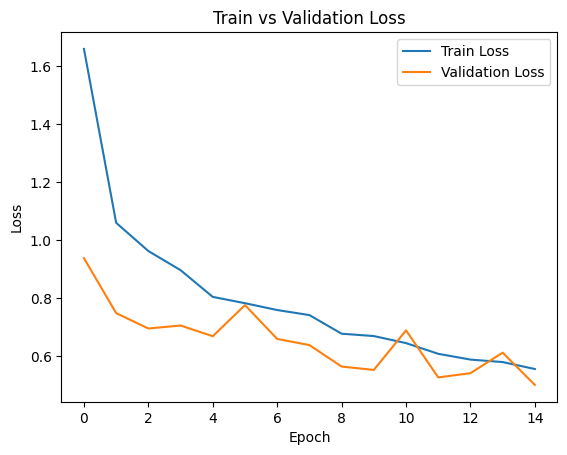


=== Test Set Final Results ===
Test Loss: 0.8599
Test Mae: 4.6480
Precision: 0.9063
Recall: 0.9425
F1 Score: 0.9241


In [ ]:
# === Paramètres ===
num_epochs = 15
learning_rate = 0.001  # corrigé: meilleure valeur observée
dropout_rate = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Modèle InceptionV3 pré-entraiîné ===
inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
num_features = inception.fc.in_features
inception.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(256, 2)
)
inception = inception.to(device)

# === Pertes et optimiseur ===
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(inception.parameters(), lr=learning_rate)

# === Early Stopping ===
patience = 3
best_val_loss = float('inf')
no_improve_count = 0
model_path = "best_inception_model.pth"

train_losses, val_losses = [], []

# === Entraînement ===
for epoch in range(num_epochs):
    inception.train()
    total_train_loss = 0.0

    for images, labels_dict in tqdm(train_loader_1):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)


        optimizer.zero_grad()
        outputs = inception(images)
        if isinstance(outputs, tuple): outputs = outputs[0]

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages) / 100
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.7 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader_1)
    train_losses.append(avg_train_loss)

    # === Validation ===
    inception.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, labels_dict in tqdm(val_loader_1):
            images = images.to(device)
            ages = labels_dict["age"].to(device)
            genders = labels_dict["gender"].to(device)


            outputs = inception(images)
            if isinstance(outputs, tuple): outputs = outputs[0]

            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            loss_age = criterion_age(predicted_age, ages) / 100
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.7 * loss_age + loss_gender

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader_1)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_count = 0
        torch.save(inception.state_dict(), model_path)
        print(f"Validation Loss improved. Model saved at epoch {epoch+1}.")
    else:
        no_improve_count += 1
        print(f"No improvement in Validation Loss for {no_improve_count} epoch(s).")
        if no_improve_count >= patience:
            print(f"Early Stopping triggered at epoch {epoch+1}.")
            break

# === Récupérer le meilleur modèle ===
inception.load_state_dict(torch.load(model_path))
print("Best model reloaded for testing.")

# === Visualisation des pertes ===
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Validation Loss")
plt.show()

# === Évaluation sur le test set ===
def evaluate_model(model, test_loader, criterion_age, criterion_gender, device):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels_dict in test_loader:
            images = images.to(device)
            ages = labels_dict["age"].to(device)
            genders = labels_dict["gender"].to(device)


            outputs = model(images)
            if isinstance(outputs, tuple): outputs = outputs[0]

            predicted_age = outputs[:, 0]
            predicted_gender = torch.sigmoid(outputs[:, 1])
            predicted_gender_binary = (predicted_gender > 0.5).float()

            loss_age = criterion_age(predicted_age, ages) / 100
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.7 * loss_age + loss_gender

            total_loss += loss.item()
            total_mae += torch.mean(torch.abs(predicted_age - ages)).item()

            y_true.extend(genders.cpu().numpy())
            y_pred.extend(predicted_gender_binary.cpu().numpy())

    return {
        "test_loss": total_loss / len(test_loader),
        "test_mae": total_mae / len(test_loader),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred)
    }

final_results = evaluate_model(
    model=inception,
    test_loader=test_loader_1,
    criterion_age=criterion_age,
    criterion_gender=criterion_gender,
    device=device
)

print("\n=== Test Set Final Results ===")
for k, v in final_results.items():
    print(f"{k.replace('_', ' ').title()}: {v:.4f}")
